In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D

import keras_tuner

#import custom modules
import sys
sys.path.insert(0, '/Users/frederickkorbel/Documents/projects/paper/mlcis/utils')

import integrated_gradients as ig
from metaplot import Metaplot, one_hot_encode
import my_utils as ut
import plotseqlogo as sql

#set seaborn style
sns.set_style('ticks')

/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/plotseqlogo.py:54: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/plotseqlogo.py:55: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [4]:
def test_data(df, model, test_seq, obs_col = 'rl', output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def plot_meta(data, model, subset=None):

    if subset is None:
        print(len(data))
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        Metaplot(data_ig, colorbar = True)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)]
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        Metaplot(lowest_ten_ig, colorbar = True)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)]
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        Metaplot(highest_ten_ig, colorbar = True)
        
    else:
        raise ValueError()

def plot_attribution(data, model, subset=None, samples=10):
    if subset is None:
        print(len(data))
        data = data.sample(n=samples)
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        sql.seqlogo_fig(np.transpose(data_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)].sample(n=samples)
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        sql.seqlogo_fig(np.transpose(lowest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)].sample(n=samples)
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        sql.seqlogo_fig(np.transpose(highest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
        
    else:
        raise ValueError()

<font color=white size=20>Testing Models on Human Data</font>

2022-08-20 20:00:55.890890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-20 20:00:56.270007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


0.8005493284758706


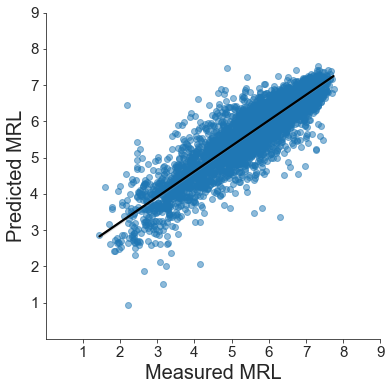

In [3]:
#performance of hMRL model on human test data
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])

hMRL_on_human=test_data(df=test_human, model=keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model.hdf5'), obs_col='rl',test_seq=metaplot.one_hot_encode(test_human, seq_len=50))
ut.corplot(hMRL_on_human)

0.7894501741268782


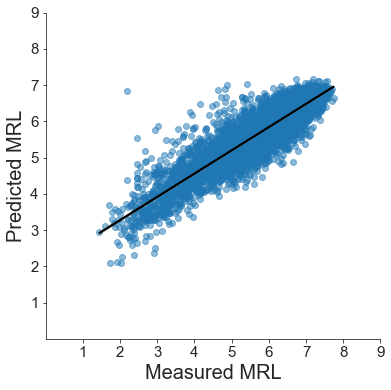

In [4]:
#performance of Optimus-5-Prime model on human test data
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])
O5P_on_human=test_data(df=test_human, model=keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/main_MRL_model.hdf5'), obs_col='rl', test_seq=metaplot.one_hot_encode(test_human,seq_len=50))

ut.corplot(O5P_on_human)

<font color=white size=20> Defining Datasets</font>

In [3]:
#defining the two datasets for subsequent training
train_synthetic=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_train.csv.gz', compression='gzip', index_col=[0])
train_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_train.csv', index_col=[0])

#the dataset to optimize for and test performance on
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])

#one-hot-encode all datasets
train_synthetic_seq=one_hot_encode(train_synthetic)
train_human_seq=one_hot_encode(train_human)

test_human_seq=one_hot_encode(test_human)

#scale MRL values
test_human.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(test_human.loc[:,'rl'].values.reshape(-1,1))
train_human.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(train_human.loc[:,'rl'].values.reshape(-1,1))


<font color=white size=20> KerasTuner Search </font>

In [6]:
epochs_hum=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

class OptimizedModel(keras_tuner.HyperModel):

    def build(self, hp):
        return keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/main_MRL_model.hdf5')

    def fit(self, hp, model, *args, **kwargs):
        #model.fit(*args, batch_size=128, epochs=hp.Choice('epochs', epochs_syn), **kwargs)
        return model.fit(*args, batch_size=128, epochs=hp.Choice('epochs', epochs_hum), **kwargs)


tuner=keras_tuner.RandomSearch(
    hypermodel=OptimizedModel(),
    objective='val_loss',
    max_trials=15,
    overwrite=True,
    directory='/Users/frederickkorbel/Documents/projects/paper/mlcis/models/tune_mrl_model',
    project_name='tune_mrl_model')

tuner.search(train_human_seq,train_human['scaled_rl'], validation_data=(test_human_seq, test_human['scaled_rl']))

tuner.results_summary(num_trials=15)



Trial 14 Complete [00h 05m 50s]
val_loss: 0.15048740804195404

Best val_loss So Far: 0.14294536411762238
Total elapsed time: 00h 49m 19s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /Users/frederickkorbel/Documents/projects/paper/mlcis/models/tune_mrl_model/tune_mrl_model
Showing 15 best trials
Trial summary
Hyperparameters:
epochs: 10
Score: 0.14294536411762238
Trial summary
Hyperparameters:
epochs: 7
Score: 0.14442886412143707
Trial summary
Hyperparameters:
epochs: 15
Score: 0.1475960910320282
Trial summary
Hyperparameters:
epochs: 13
Score: 0.14890407025814056
Trial summary
Hyperparameters:
epochs: 6
Score: 0.1493527889251709
Trial summary
Hyperparameters:
epochs: 8
Score: 0.14955487847328186
Trial summary
Hyperparameters:
epochs: 9
Score: 0.15002675354480743
Trial summary
Hyperparameters:
epochs: 14
Score: 0.1502436101436615
Trial summary
Hyperparameters:
epochs: 11
Score: 0.15048740804195404
Trial summary
Hyperparameters:
epochs: 4
Score: 0.15455542504787445
Tr

In [7]:
#reload the tuner to access trials
epochs_hum=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

class OptimizedModel(keras_tuner.HyperModel):

    def build(self, hp):
        return keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/main_MRL_model.hdf5')

    def fit(self, hp, model, *args, **kwargs):
        #model.fit(*args, batch_size=128, epochs=hp.Choice('epochs', epochs_syn), **kwargs)
        return model.fit(*args, batch_size=128, epochs=hp.Choice('epochs', epochs_hum), **kwargs)
        
tuner=keras_tuner.RandomSearch(
    hypermodel=OptimizedModel(),
    objective='val_loss',
    max_trials=15,
    overwrite=False,
    directory='/Users/frederickkorbel/Documents/projects/paper/mlcis/models/tune_mrl_model',
    project_name='tune_mrl_model')

INFO:tensorflow:Reloading Oracle from existing project /Users/frederickkorbel/Documents/projects/paper/mlcis/models/tune_mrl_model/tune_mrl_model/oracle.json


2022-08-22 10:47:40.286267: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Reloading Tuner from /Users/frederickkorbel/Documents/projects/paper/mlcis/models/tune_mrl_model/tune_mrl_model/tuner0.json


In [8]:
best_model=tuner.get_best_models()[0]

#save best model
#best_model.save('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/OptMRL_model.hdf5')

In [13]:
#test all generated models from best to worst

r2_list=[]

for model in tuner.get_best_models(num_models=15):
    tmp=test_data(test_human, model, test_human_seq, obs_col='rl', output_col='pred')
    r2_list.append(ut.r2(tmp['rl'], tmp['pred']))

r2_list

[0.8599537395147854,
 0.8597698839792377,
 0.8554960244743738,
 0.8566347950637445,
 0.855668858190552,
 0.8551088072996201,
 0.8557929961199418,
 0.8564763181950396,
 0.8524646005375842,
 0.8592762070350467,
 0.8572798777198894,
 0.8423510898617671,
 0.848503025390872,
 0.8419659720282672]

In [4]:
best_model=keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/OptMRL_model.hdf5')

2022-12-05 16:19:11.652790: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-11-18 10:30:40.699956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


r-squared =  0.8599537395147854


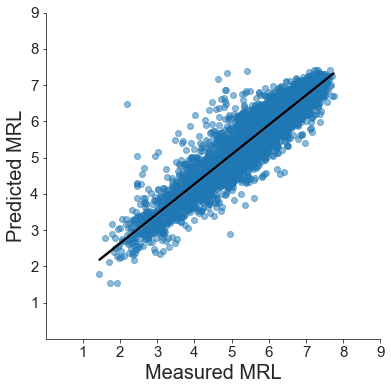

In [5]:
#performance of the optimized model (OptMRL) on human test data
OPT_human_test_pred=test_data(test_human, best_model, test_human_seq, obs_col='rl', output_col='pred')

r_2 = ut.r2(OPT_human_test_pred['rl'], OPT_human_test_pred['pred'])
print('r-squared = ', r_2)
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = OPT_human_test_pred, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(0,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(1,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()

#save predictions
#OPT_human_test_pred.to_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/OptMRL_human_test_pred.csv')



<font color=white size=20> We attribute the model on human data</font>

10


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


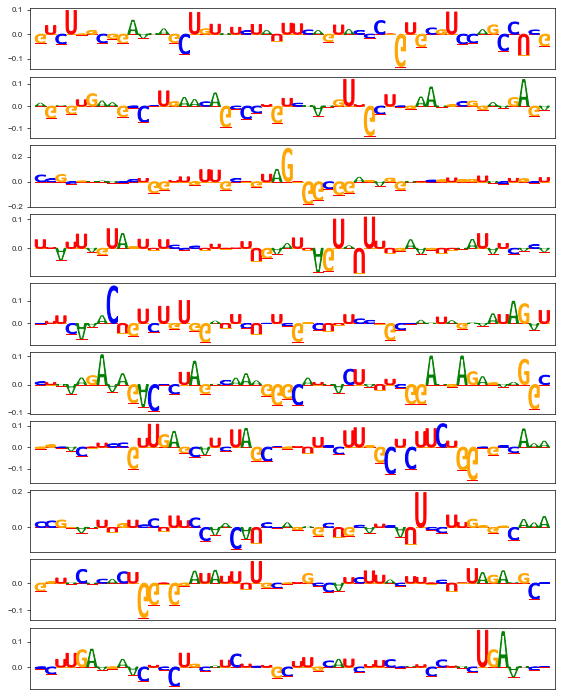

In [7]:
#we attribute the optimized MRL model to understand which features the model relies on to make predictions
plot_attribution(test_human, best_model, subset='highest_ten', samples=10)


500


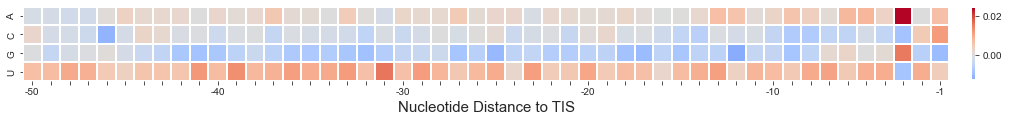

In [8]:
plot_meta(test_human, best_model, subset='highest_ten')

10


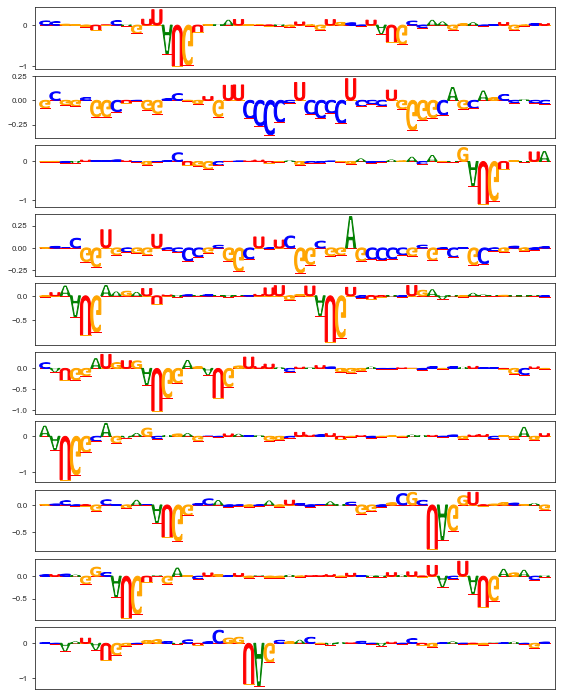

In [9]:
plot_attribution(test_human, best_model, subset='lowest_ten', samples=10)

500


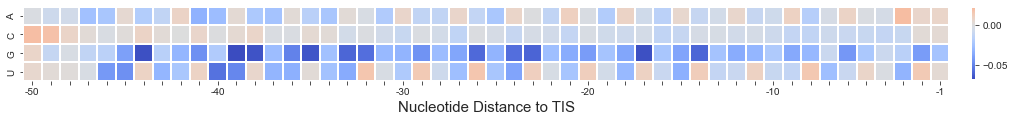

In [10]:
plot_meta(test_human, best_model, subset='lowest_ten')

In [11]:
#remove AUGs to reveal other signals learned by the OptMRL model
test_human_no_aug=test_human[test_human['utr'].apply(lambda x: 'ATG' not in x)]
test_human_no_ug = test_human_no_aug[test_human_no_aug['utr'].apply(lambda x: x.startswith('TG')== False)]

3


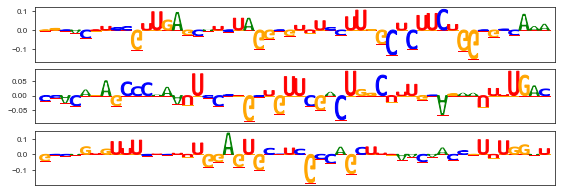

In [12]:
plot_attribution(test_human_no_ug, best_model, subset='highest_ten', samples=3)

386


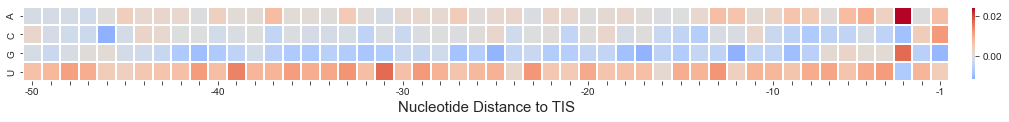

In [13]:
plot_meta(test_human_no_ug, best_model, subset='highest_ten')

3


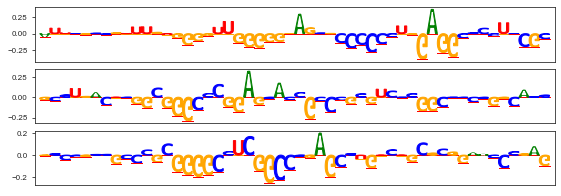

In [14]:
plot_attribution(test_human_no_ug, best_model, subset='lowest_ten', samples=3)

386


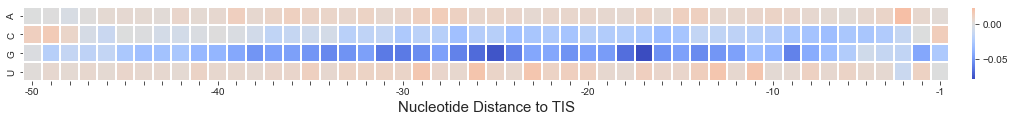

In [15]:
plot_meta(test_human_no_ug, best_model, subset='lowest_ten')

0.7681689587660553


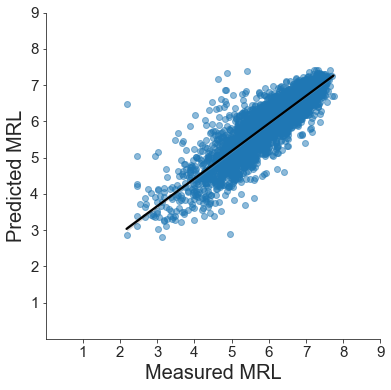

In [16]:
ut.corplot(test_human_no_ug)

In [17]:
len(test_human_no_ug)

3853

r-squared =  0.9116071922604368


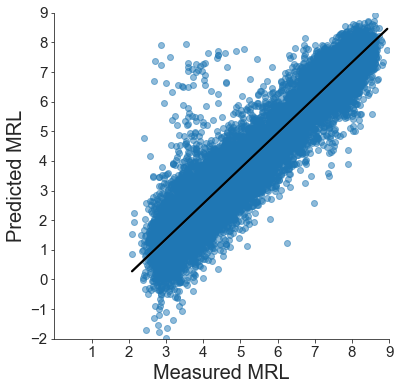

In [18]:
#import the synthetic test data
test_synthetic=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv', index_col=[0])

#make predictions
OPT_synthetic_test_pred=test_data(test_synthetic, best_model, one_hot_encode(test_synthetic), obs_col='rl', output_col='pred')

r_2 = ut.r2(OPT_synthetic_test_pred['rl'], OPT_synthetic_test_pred['pred'])
print('r-squared = ', r_2)
g, ax = plt.subplots(figsize=(6,6))
g = sns.regplot(data = OPT_synthetic_test_pred, x = 'rl', y = 'pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"})
g.set(ylim=(-2,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(-2,10,1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Measured MRL', fontsize=20)
plt.ylabel('Predicted MRL', fontsize=20)
sns.despine()

<font color=white size=20> O5P on human UTRs</font>

In [19]:
#import original mrl model (Optimus-5-Prime)
mrl_model=keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/main_MRL_model.hdf5')

#import unchanged human test set
h_test=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])

#make predictions on human test data
MRL_human_test_pred=test_data(h_test, mrl_model, one_hot_encode(h_test), obs_col='rl', output_col='pred')

500


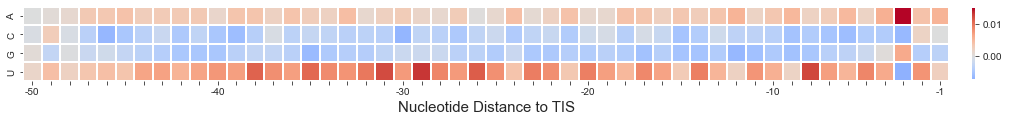

500


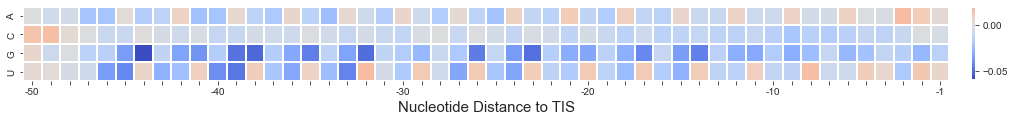

In [20]:
plot_meta(MRL_human_test_pred, mrl_model, subset='highest_ten')
plot_meta(MRL_human_test_pred, mrl_model, subset='lowest_ten')

386


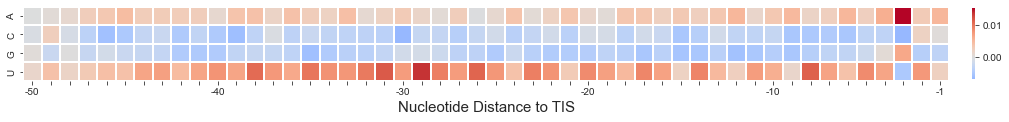

386


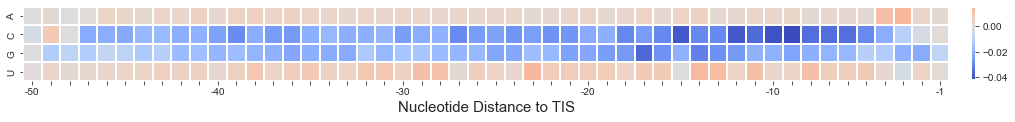

In [21]:
#remove AUGs and attribute
h_test_no_aug=h_test[h_test['utr'].apply(lambda x: 'ATG' not in x)]
h_test_no_ug=h_test_no_aug[h_test_no_aug['utr'].apply(lambda x: x.startswith('TG')== False)]

plot_meta(h_test_no_ug, mrl_model, subset='highest_ten')
plot_meta(h_test_no_ug, mrl_model, subset='lowest_ten')

0.6428254817298426


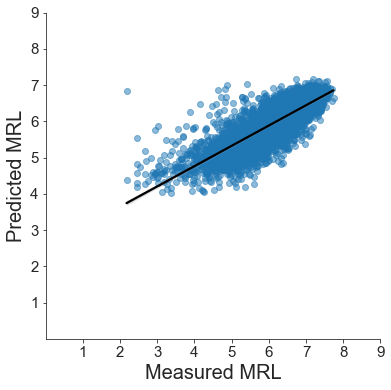

In [22]:
ut.corplot(h_test_no_ug)

<font size=20> Overview of Model Performance </font>

In [42]:
#performance of Optimus-5-Prime, hMRL and OptMRL on synthetic and random test data

#load models
mrl_model=keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/main_MRL_model.hdf5')
hmrl_model=keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model.hdf5')
best_model=keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/OptMRL_model.hdf5')

#import synthetic and human test dataset
test_synthetic=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv', index_col=[0])
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])

#one-hot encode seqs
test_synthetic_seq=one_hot_encode(test_synthetic)
test_human_seq=one_hot_encode(test_human)

#O5P
test_synthetic=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv', index_col=[0])
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])
O5P_synthetic=test_data(test_synthetic, mrl_model, test_synthetic_seq, obs_col='rl', output_col='pred')
O5P_human=test_data(test_human, mrl_model, test_human_seq, obs_col='rl', output_col='pred')
#hMRL
test_synthetic=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv', index_col=[0])
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])
hMRL_synthetic=test_data(test_synthetic, hmrl_model, test_synthetic_seq, obs_col='rl', output_col='pred')
hMRL_human=test_data(test_human, hmrl_model, test_human_seq, obs_col='rl', output_col='pred')
#OptMRL
test_synthetic=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/random_test.csv', index_col=[0])
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/human_test.csv', index_col=[0])
OptMRL_synthetic=test_data(test_synthetic, best_model, test_synthetic_seq, obs_col='rl', output_col='pred')
OptMRL_human=test_data(test_human, best_model, test_human_seq, obs_col='rl', output_col='pred')

data_list=[O5P_synthetic, hMRL_synthetic, OptMRL_synthetic, O5P_human, hMRL_human, OptMRL_human]
#compute r2
rsquared_all=[]
for x in data_list:
    rsquared_all.append(round(ut.r2(x['rl'], x['pred']), 3))

#sample size
samplesize_all=[]
for j in data_list:
    samplesize_all.append(len(j))

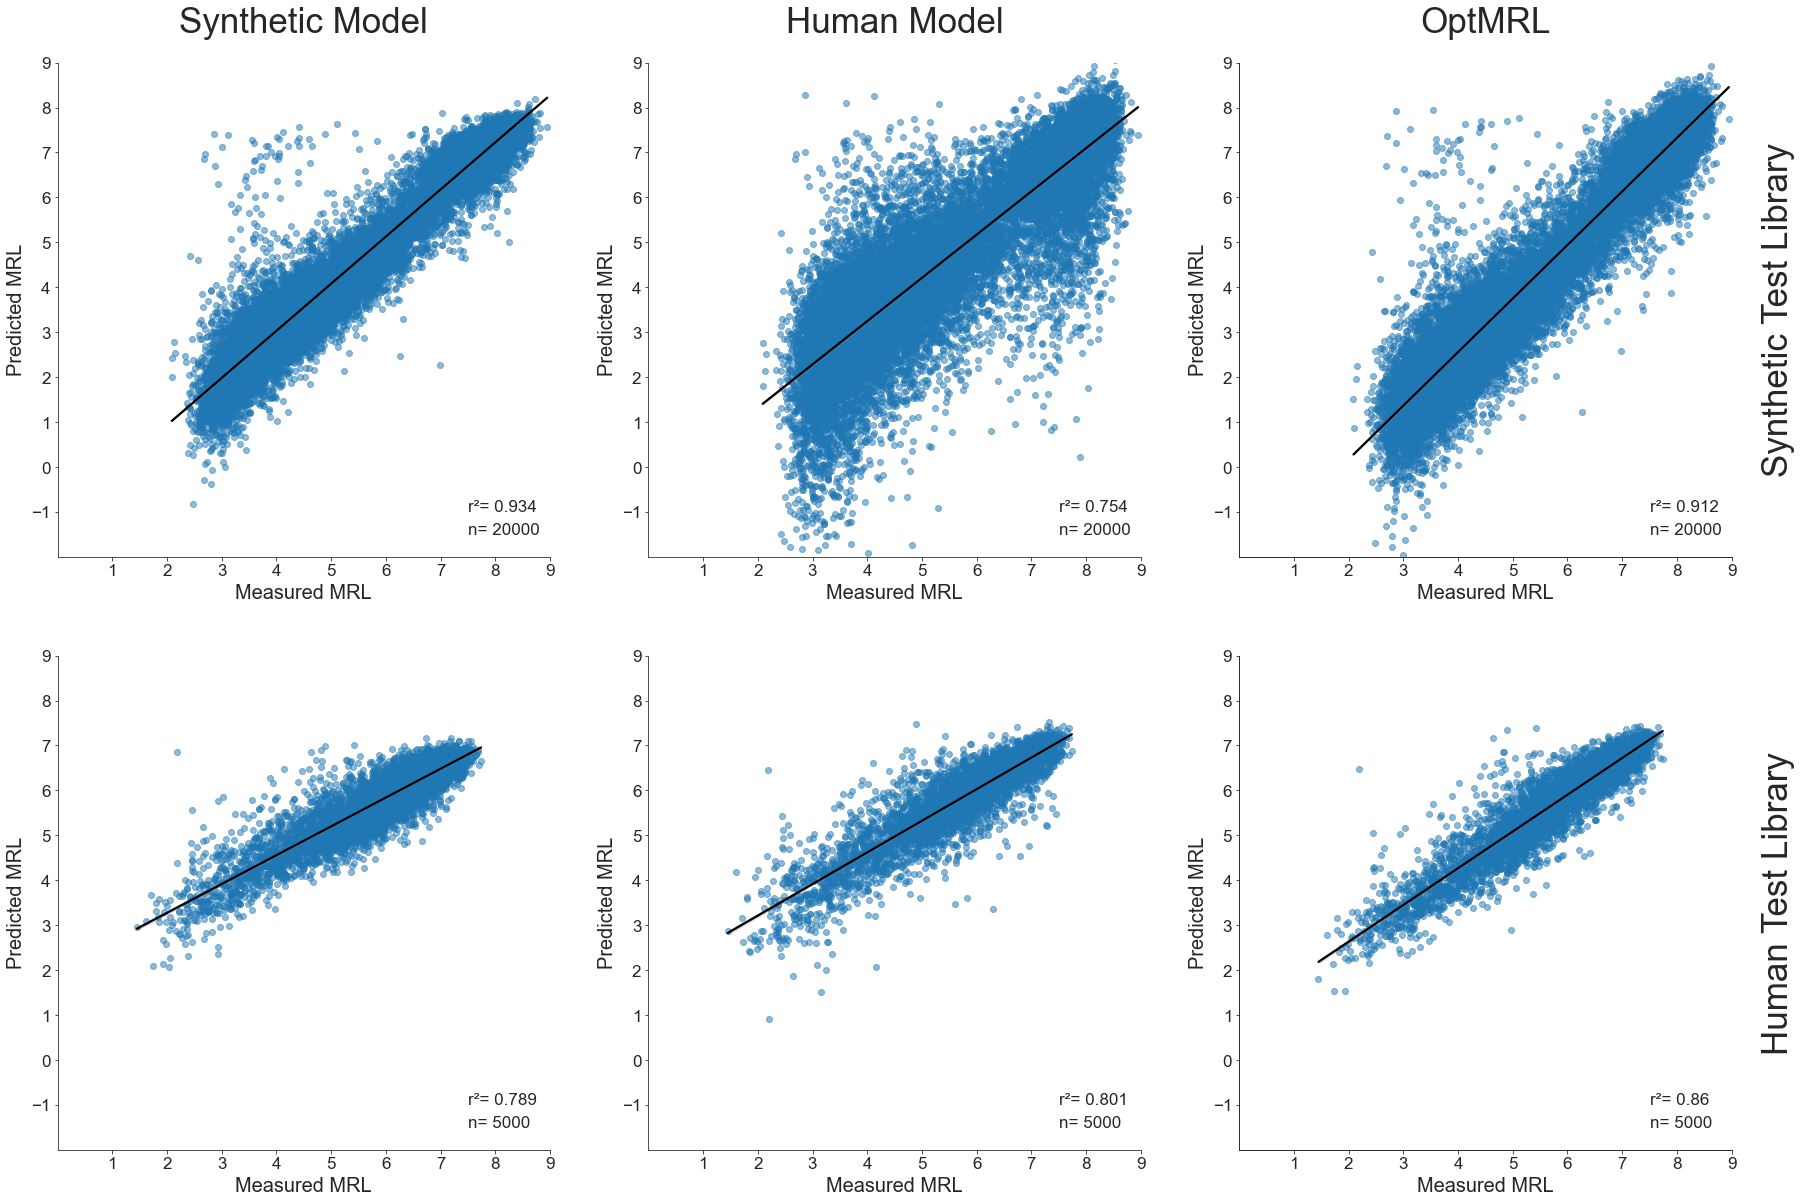

In [62]:
#subplot which to give overview over performance of the models on synthetic and human reporter data


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30,20))
for dataset, ax in zip(data_list, axs.flat):
    sns.regplot(data=dataset, x='rl', y='pred', scatter_kws={'alpha':0.5}, line_kws={"color": "black"}, ax=ax)

for ax, mo in zip(axs[0], ['Synthetic Model', 'Human Model', 'OptMRL']):
    ax.set_title('{}'.format(mo), size=35, pad=30)

for ax, dat in zip(axs[:, 2], ['Synthetic Test Library', 'Human Test Library']):
    ax2=ax.twinx()
    ax2.set_ylabel('{}'.format(dat), size=35, labelpad=30)
    ax2.set_yticks([])

for (rsquared, samplesize, ax) in zip(rsquared_all, samplesize_all, axs.flat):
    ax.set_xlabel('Measured MRL', size=20, labelpad=5)
    ax.set_ylabel('Predicted MRL', size=20, labelpad=5)
    ax.tick_params(axis='x', labelsize=17)
    ax.tick_params(axis='y', labelsize=17)
    ax.annotate('{}\u00b2= {}'.format('r', rsquared), xy=(7.5,-1), fontsize=17)
    ax.annotate('n= {}'.format(samplesize), xy=(7.5,-1.5), fontsize=17)

plt.setp(axs, ylim=(-2,9), xlim=(0,9), xticks = range(1,10,1), yticks = range(-1,10,1))
sns.despine()
plt.show()